# Natural Language Processing with TensorFlow

## Prep Models

### Preliminaries (preparing data)

In [ ]:
# Check for GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-145201ef-f9fb-f34c-c53b-b326ff76d704)


In [ ]:
# Download helper functions script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-03-09 10:46:30--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-03-09 10:46:30 (71.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Import series of helper functions for the notebook
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

In [ ]:
# Download data (same as from Kaggle)
!wget "https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip"

# Unzip data
unzip_data("nlp_getting_started.zip")

--2023-03-09 10:46:34--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.217.128, 173.194.215.128, 108.177.11.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.217.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.005s  

2023-03-09 10:46:34 (119 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



In [ ]:
# Turn .csv files into pandas DataFrame's
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42) # shuffle with random_state=42 for reproducibility
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [ ]:
# The test data doesn't have a target (that's what we'd try to predict)
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [ ]:
# How many examples of each class?
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [ ]:
# How many samples total?
print(f"Total training samples: {len(train_df)}")
print(f"Total test samples: {len(test_df)}")
print(f"Total samples: {len(train_df) + len(test_df)}")

Total training samples: 7613
Total test samples: 3263
Total samples: 10876


In [ ]:
# Let's visualize some random training examples
import random
random_index = random.randint(0, len(train_df)-5) # create random indexes not higher than the total number of samples
for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
  print(f"Text:\n{text}\n")
  print("---\n")

Target: 1 (real disaster)
Text:
when a monster truck racer catches on fire at the fair

---

Target: 0 (not real disaster)
Text:
China's Stock Market Crash: Are There Gems In The Rubble?: ChinaÛªs stock market crash this summer h... http://t.co/pE2R3lN16o by .Forbes

---

Target: 1 (real disaster)
Text:
GAElite 0    Explosion Greg 2 [Top 3rd] [0 Out] [0 balls] [0 strikes] ... No one on [P: #16 Morgan Orchard] [B: ]

---

Target: 0 (not real disaster)
Text:
Is it possible to sneak into a hospital so I can stab myself with a hazardous needle and inject some crazy disease into my veins until I die

---

Target: 0 (not real disaster)
Text:
@EBROINTHEAM jay....big L....pun....biggie...wrap over...zero question....fatality...flawless victory http://t.co/Y33QcKq7qD

---



In [ ]:
from sklearn.model_selection import train_test_split

# Use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.1, # dedicate 10% of samples to validation set
                                                                            random_state=42) # random state for reproducibility

In [ ]:
train_sentences

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       ...,
       'Near them on the sand half sunk a shattered visage lies... http://t.co/0kCCG1BT06',
       "kesabaran membuahkan hasil indah pada saat tepat! life isn't about waiting for the storm to pass it's about learning to dance in the rain.",
       "@ScottDPierce @billharris_tv @HarrisGle @Beezersun I'm forfeiting this years fantasy football pool out of fear I may win n get my ass kicked"],
      dtype=object)

In [ ]:
val_sentences

array(['DFR EP016 Monthly Meltdown - On Dnbheaven 2015.08.06 http://t.co/EjKRf8N8A8 #Drum and Bass #heavy #nasty http://t.co/SPHWE6wFI5',
       'FedEx no longer to transport bioterror germs in wake of anthrax lab mishaps http://t.co/qZQc8WWwcN via @usatoday',
       'Gunmen kill four in El Salvador bus attack: Suspected Salvadoran gang members killed four people and wounded s... http://t.co/CNtwB6ScZj',
       '@camilacabello97 Internally and externally screaming',
       'Radiation emergency #preparedness starts with knowing to: get inside stay inside and stay tuned http://t.co/RFFPqBAz2F via @CDCgov',
       'Investigators rule catastrophic structural failure resulted in 2014 Virg.. Related Articles: http://t.co/Cy1LFeNyV8',
       'How the West was burned: Thousands of wildfires ablaze in #California alone http://t.co/iCSjGZ9tE1 #climate #energy http://t.co/9FxmN0l0Bd',
       "Map: Typhoon Soudelor's predicted path as it approaches Taiwan; expected to make landfall over southern C

In [ ]:
train_labels

array([0, 0, 1, ..., 1, 1, 0])

In [ ]:
val_labels

array([0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0,
       1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0,
       1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0,

In [ ]:
# Check the lengths
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [ ]:
762/6851

0.11122463873887024

### Preprocessing Data: converting text into numbers

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
# Note: in TensorFlow 2.6+, you no longer need "layers.experimental.preprocessing"
# you can use: "tf.keras.layers.TextVectorization", see https://github.com/tensorflow/tensorflow/releases/tag/v2.6.0 for more

# Use the default TextVectorization variables
text_vectorizer = TextVectorization(max_tokens=None, # how many words in the vocabulary (all of the different words in your text)
                                    standardize="lower_and_strip_punctuation", # how to process text
                                    split="whitespace", # how to split tokens
                                    ngrams=None, # create groups of n-words?
                                    output_mode="int", # how to map tokens to numbers
                                    output_sequence_length=None) # how long should the output sequence of tokens be?
                                    # pad_to_max_tokens=True) # Not valid if using max_tokens=None

In [ ]:
# Find average number of tokens (words) in training Tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [ ]:
# Setup text vectorization with custom variables
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 15 # max length our sequences will be (e.g. how many words from a Tweet does our model see?)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)


In [ ]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [ ]:
# Create sample sentence and tokenize it
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [ ]:
# Choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nVectorized version:")
text_vectorizer([random_sentence])

Original text:
Hail Mary Full of Grace The Lord is with thee. Blessed art thou among women and blessed is the fruit of thy... http://t.co/IDQcfJycYM      

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[ 348, 1640,  120,    6, 2444,    2,  774,    9,   14, 4437, 2182,
        1095, 7596, 1558,  427]])>

In [ ]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5] # most common tokens (notice the [UNK] token for "unknown" words)
bottom_5_words = words_in_vocab[-5:] # least common tokens
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}") 
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
Top 5 most common words: ['', '[UNK]', 'the', 'a', 'in']
Bottom 5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


In [ ]:
tf.random.set_seed(42)
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length, # set input shape
                             output_dim=128, # set size of embedding vector
                             embeddings_initializer="uniform", # default, intialize randomly
                             input_length=max_length, # how long is each input
                             name="embedding_1") 

embedding

In [ ]:
# Get a random sentence from training set
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nEmbedded version:")

# Embed the random sentence (turn it into numerical representation)
sample_embed = embedding(text_vectorizer(random_sentence))
sample_embed

Original text:
#BakeOffFriends #GBBO 'The one with the mudslide and the guy with the hat'      

Embedded version:


<tf.Tensor: shape=(15, 128), dtype=float32, numpy=
array([[ 0.02258914, -0.0328256 , -0.03352322, ..., -0.03049957,
         0.01006424,  0.0230929 ],
       [-0.00647489, -0.02963029, -0.00026202, ...,  0.03635092,
        -0.03148109,  0.0450667 ],
       [-0.04953344,  0.036684  , -0.01231069, ...,  0.04043497,
        -0.02611907,  0.03638512],
       ...,
       [-0.03815453, -0.04686433,  0.02286625, ...,  0.00896521,
         0.00348733, -0.04478719],
       [ 0.03699349,  0.04029262,  0.01513887, ..., -0.01997277,
        -0.04146808, -0.00073756],
       [ 0.03699349,  0.04029262,  0.01513887, ..., -0.01997277,
        -0.04146808, -0.00073756]], dtype=float32)>

In [ ]:
# Check out a single token's embedding
sample_embed[0]

<tf.Tensor: shape=(128,), dtype=float32, numpy=
array([ 0.02258914, -0.0328256 , -0.03352322, -0.00475681,  0.00590106,
       -0.03397115, -0.01000732,  0.01234797,  0.01193665, -0.00142999,
        0.01682477,  0.03373117,  0.0144166 ,  0.01635833, -0.0426695 ,
        0.01600275,  0.03136234, -0.00900242, -0.04932749,  0.00088181,
        0.02424473, -0.01096155, -0.01212979, -0.00111594, -0.03948673,
        0.01093086, -0.0105121 , -0.02021445, -0.01478152,  0.02743297,
       -0.01727598,  0.03145844,  0.03787445,  0.03303855,  0.0334017 ,
        0.0304861 , -0.00187528,  0.03098372,  0.03355292, -0.00918405,
        0.01050675, -0.03174251, -0.0072269 ,  0.04835366,  0.00743046,
       -0.00619966, -0.00558877, -0.01047661, -0.02121247,  0.00877158,
        0.01859404,  0.04631796, -0.02384621,  0.00635237,  0.036753  ,
        0.03095888, -0.04266289, -0.03536557, -0.0424868 ,  0.03726509,
       -0.03061731,  0.01898145, -0.03370011, -0.01182084, -0.02102624,
       -0.007587

### Model 0: baseline

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                    ("clf", MultinomialNB()) # model the text
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 79.27%


In [ ]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

In [ ]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
  -----
  y_true = true labels in the form of a 1D array
  y_pred = predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [ ]:
val_labels

array([0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0,
       1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0,
       1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0,

In [ ]:
baseline_preds

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,

In [ ]:
# Get baseline results
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

### Model 1: A simple dense model

In [ ]:
# Create tensorboard callback (need to create a new one for each model)
from helper_functions import create_tensorboard_callback

# Create directory to save TensorBoard logs
SAVE_DIR = "model_logs"

In [ ]:
# Build model with the Functional API
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string") # inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding(x) # create an embedding of the numerized numbers
x = layers.GlobalAveragePooling1D()(x) # lower the dimensionality of the embedding (try running the model without this layer and see what happens)
outputs = layers.Dense(1, activation="sigmoid")(x) # create the output layer, want binary outputs so use sigmoid activation
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense") # construct the model

In [ ]:
# Compile model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Get a summary of the model
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [ ]:
# Fit the model
model_1_history = model_1.fit(train_sentences, # input sentences can be a list of strings due to text preprocessing layer built-in model
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR, 
                                                                     experiment_name="simple_dense_model")])

Saving TensorBoard log files to: model_logs/simple_dense_model/20230309-104640
Epoch 1/5
215/215 [==============================] - 15s 46ms/step - loss: 0.6077 - accuracy: 0.6980 - val_loss: 0.5348 - val_accuracy: 0.7572
Epoch 2/5
215/215 [==============================] - 2s 9ms/step - loss: 0.4402 - accuracy: 0.8193 - val_loss: 0.4688 - val_accuracy: 0.7861
Epoch 3/5
215/215 [==============================] - 2s 8ms/step - loss: 0.3455 - accuracy: 0.8610 - val_loss: 0.4588 - val_accuracy: 0.7913
Epoch 4/5
215/215 [==============================] - 1s 6ms/step - loss: 0.2839 - accuracy: 0.8927 - val_loss: 0.4641 - val_accuracy: 0.7900
Epoch 5/5
215/215 [==============================] - 2s 8ms/step - loss: 0.2371 - accuracy: 0.9130 - val_loss: 0.4768 - val_accuracy: 0.7874


In [ ]:
# Check the results
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 2ms/step - loss: 0.4768 - accuracy: 0.7874


[0.47683408856391907, 0.787401556968689]

In [ ]:
embedding.weights

[<tf.Variable 'embedding_1/embeddings:0' shape=(10000, 128) dtype=float32, numpy=
 array([[ 0.05144857,  0.05616488,  0.02435024, ..., -0.03567006,
         -0.02996483, -0.01225688],
        [-0.01481388,  0.04336834,  0.02260932, ...,  0.02486599,
         -0.0217491 ,  0.0352694 ],
        [-0.03192432,  0.05444868,  0.01312056, ...,  0.02236268,
         -0.00952182,  0.01660783],
        ...,
        [ 0.03889653,  0.03669694,  0.00694102, ...,  0.02156445,
         -0.03382589,  0.01587072],
        [ 0.03245229,  0.06865674,  0.07273931, ..., -0.04856863,
          0.04737454, -0.08052557],
        [ 0.10823079,  0.07635431,  0.06128707, ..., -0.03860988,
          0.07060412, -0.09856522]], dtype=float32)>]

In [ ]:
embed_weights = model_1.get_layer("embedding_1").get_weights()[0]
print(embed_weights.shape)

(10000, 128)


In [ ]:
# Make predictions (these come back in the form of probabilities)
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs[:10] # only print out the first 10 prediction probabilities

24/24 [==============================] - 0s 2ms/step


array([[0.4095547 ],
       [0.74371755],
       [0.9979221 ],
       [0.11011279],
       [0.10474717],
       [0.9402221 ],
       [0.9192008 ],
       [0.99257267],
       [0.9709669 ],
       [0.2612345 ]], dtype=float32)

In [ ]:
# Turn prediction probabilities into single-dimension tensor of floats
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs)) # squeeze removes single dimensions
model_1_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

In [ ]:
# Calculate model_1 metrics
model_1_results = calculate_results(y_true=val_labels, 
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.74015748031496,
 'precision': 0.7914920592553047,
 'recall': 0.7874015748031497,
 'f1': 0.7846966492209201}

In [ ]:
# Is our simple Keras model better than our baseline model?
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

In [ ]:
# Create a helper function to compare our baseline results to new model results
def compare_baseline_to_new_results(baseline_results, new_model_results):
  for key, value in baseline_results.items():
    print(f"Baseline {key}: {value:.2f}, New {key}: {new_model_results[key]:.2f}, Difference: {new_model_results[key]-value:.2f}")

compare_baseline_to_new_results(baseline_results=baseline_results, 
                                new_model_results=model_1_results)

Baseline accuracy: 79.27, New accuracy: 78.74, Difference: -0.52
Baseline precision: 0.81, New precision: 0.79, Difference: -0.02
Baseline recall: 0.79, New recall: 0.79, Difference: -0.01
Baseline f1: 0.79, New f1: 0.78, Difference: -0.00


In [ ]:
# Get the vocabulary from the text vectorization layer
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [ ]:
# Get the weight matrix of embedding layer 
# (these are the numerical patterns between the text in the training dataset the model has learned)
embed_weights = model_1.get_layer("embedding_1").get_weights()[0]
print(embed_weights.shape) # same size as vocab size and embedding_dim (each word is a embedding_dim size vector)

(10000, 128)


### Model 2: LSTM

In [ ]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_2_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_2")


# Create LSTM model
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_2_embedding(x)
print(x.shape)
# x = layers.LSTM(64, return_sequences=True)(x) # return vector for each word in the Tweet (you can stack RNN cells as long as return_sequences=True)
x = layers.LSTM(64)(x) # return vector for whole sequence
print(x.shape)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer on top of output of LSTM cell
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

(None, 15, 128)
(None, 64)


In [ ]:
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_2 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
____________________________________________

In [ ]:
# Compile model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Fit model
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 
                                                                     "LSTM")])

Saving TensorBoard log files to: model_logs/LSTM/20230309-104703
Epoch 1/5
215/215 [==============================] - 11s 34ms/step - loss: 0.5072 - accuracy: 0.7451 - val_loss: 0.4570 - val_accuracy: 0.7795
Epoch 2/5
215/215 [==============================] - 2s 9ms/step - loss: 0.3161 - accuracy: 0.8716 - val_loss: 0.5060 - val_accuracy: 0.7795
Epoch 3/5
215/215 [==============================] - 2s 9ms/step - loss: 0.2193 - accuracy: 0.9171 - val_loss: 0.5786 - val_accuracy: 0.7625
Epoch 4/5
215/215 [==============================] - 2s 7ms/step - loss: 0.1562 - accuracy: 0.9454 - val_loss: 0.6109 - val_accuracy: 0.7717
Epoch 5/5
215/215 [==============================] - 2s 8ms/step - loss: 0.1095 - accuracy: 0.9583 - val_loss: 0.7813 - val_accuracy: 0.7598


In [ ]:
val_sentences.shape

(762,)

In [ ]:
# Make predictions on the validation dataset
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs.shape, model_2_pred_probs[:10] # view the first 10

24/24 [==============================] - 0s 2ms/step


((762, 1), array([[0.01757686],
        [0.76128715],
        [0.9985599 ],
        [0.05033991],
        [0.00323191],
        [0.9983798 ],
        [0.9486714 ],
        [0.9995797 ],
        [0.9988651 ],
        [0.2133428 ]], dtype=float32))

In [ ]:
# Round out predictions and reduce to 1-dimensional array
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Calculate LSTM model results
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 75.98425196850394,
 'precision': 0.7615439957650938,
 'recall': 0.7598425196850394,
 'f1': 0.7574575318690253}

In [ ]:
# Compare model 2 to baseline
compare_baseline_to_new_results(baseline_results, model_2_results)

Baseline accuracy: 79.27, New accuracy: 75.98, Difference: -3.28
Baseline precision: 0.81, New precision: 0.76, Difference: -0.05
Baseline recall: 0.79, New recall: 0.76, Difference: -0.03
Baseline f1: 0.79, New f1: 0.76, Difference: -0.03


### Model 3: GRU

In [ ]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_3_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_3")

# Build an RNN using the GRU cell
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_3_embedding(x)
# x = layers.GRU(64, return_sequences=True) # stacking recurrent cells requires return_sequences=True
x = layers.GRU(64)(x) 
# x = layers.Dense(64, activation="relu")(x) # optional dense layer after GRU cell
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

In [ ]:
# Compile GRU model
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Fit model
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "GRU")])

Saving TensorBoard log files to: model_logs/GRU/20230309-104721
Epoch 1/5
215/215 [==============================] - 9s 32ms/step - loss: 0.5238 - accuracy: 0.7330 - val_loss: 0.4537 - val_accuracy: 0.7848
Epoch 2/5
215/215 [==============================] - 2s 9ms/step - loss: 0.3186 - accuracy: 0.8701 - val_loss: 0.4908 - val_accuracy: 0.7822
Epoch 3/5
215/215 [==============================] - 2s 9ms/step - loss: 0.2182 - accuracy: 0.9181 - val_loss: 0.5568 - val_accuracy: 0.7717
Epoch 4/5
215/215 [==============================] - 2s 7ms/step - loss: 0.1584 - accuracy: 0.9451 - val_loss: 0.6087 - val_accuracy: 0.7756
Epoch 5/5
215/215 [==============================] - 2s 7ms/step - loss: 0.1203 - accuracy: 0.9594 - val_loss: 0.6120 - val_accuracy: 0.7743


In [ ]:
# Make predictions on the validation data
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs.shape, model_3_pred_probs[:10]

24/24 [==============================] - 0s 3ms/step


((762, 1), array([[0.46042043],
        [0.886552  ],
        [0.99679714],
        [0.14555085],
        [0.01213133],
        [0.9905511 ],
        [0.67954993],
        [0.9975877 ],
        [0.9972777 ],
        [0.483165  ]], dtype=float32))

In [ ]:
# Convert prediction probabilities to prediction classes
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Calcuate model_3 results
model_3_results = calculate_results(y_true=val_labels, 
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 77.42782152230971,
 'precision': 0.7740592463511713,
 'recall': 0.7742782152230971,
 'f1': 0.7735154339779791}

In [ ]:
# Compare to baseline
compare_baseline_to_new_results(baseline_results, model_3_results)

Baseline accuracy: 79.27, New accuracy: 77.43, Difference: -1.84
Baseline precision: 0.81, New precision: 0.77, Difference: -0.04
Baseline recall: 0.79, New recall: 0.77, Difference: -0.02
Baseline f1: 0.79, New f1: 0.77, Difference: -0.01


In [ ]:
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_3 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_____________________________________________

### Model 4: Bidirectional RNN model

In [ ]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_4_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_4")

# Build a Bidirectional RNN in TensorFlow
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_4_embedding(x)
# x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x) # stacking RNN layers requires return_sequences=True
print(x.shape)
x = layers.Bidirectional(layers.LSTM(64))(x) # bidirectional goes both ways so has double the parameters of a regular LSTM layer
print(x.shape)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_Bidirectional")

(None, 15, 128)
(None, 128)


In [ ]:
# Compile
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Get a summary of our bidirectional model
model_4.summary()

Model: "model_4_Bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_4 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,378,945
Trainable params: 1,3

In [ ]:
# Fit the model (takes longer because of the bidirectional layers)
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "bidirectional_RNN")])

Saving TensorBoard log files to: model_logs/bidirectional_RNN/20230309-104739
Epoch 1/5
215/215 [==============================] - 11s 35ms/step - loss: 0.5092 - accuracy: 0.7460 - val_loss: 0.4580 - val_accuracy: 0.7782
Epoch 2/5
215/215 [==============================] - 2s 10ms/step - loss: 0.3140 - accuracy: 0.8727 - val_loss: 0.5180 - val_accuracy: 0.7743
Epoch 3/5
215/215 [==============================] - 2s 10ms/step - loss: 0.2135 - accuracy: 0.9175 - val_loss: 0.5663 - val_accuracy: 0.7625
Epoch 4/5
215/215 [==============================] - 2s 9ms/step - loss: 0.1497 - accuracy: 0.9466 - val_loss: 0.6637 - val_accuracy: 0.7795
Epoch 5/5
215/215 [==============================] - 2s 9ms/step - loss: 0.1054 - accuracy: 0.9625 - val_loss: 0.6918 - val_accuracy: 0.7703


In [ ]:
# Make predictions with bidirectional RNN on the validation data
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

24/24 [==============================] - 1s 3ms/step


array([[0.03301397],
       [0.7996691 ],
       [0.99827254],
       [0.0892454 ],
       [0.00195476],
       [0.9858708 ],
       [0.60910356],
       [0.99951875],
       [0.99905187],
       [0.22246073]], dtype=float32)

In [ ]:
# Convert prediction probabilities to labels
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Calculate bidirectional RNN model results
model_4_results = calculate_results(val_labels, model_4_preds)
model_4_results

{'accuracy': 77.03412073490814,
 'precision': 0.7715893693867238,
 'recall': 0.7703412073490814,
 'f1': 0.7684486602580174}

In [ ]:
# Check to see how the bidirectional model performs against the baseline
compare_baseline_to_new_results(baseline_results, model_4_results)

Baseline accuracy: 79.27, New accuracy: 77.03, Difference: -2.23
Baseline precision: 0.81, New precision: 0.77, Difference: -0.04
Baseline recall: 0.79, New recall: 0.77, Difference: -0.02
Baseline f1: 0.79, New f1: 0.77, Difference: -0.02


### Model 5: Conv1D

In [ ]:
# Test out the embedding, 1D convolutional and max pooling
embedding_test = embedding(text_vectorizer(["this is a test sentence"])) # turn target sentence into embedding
conv_1d = layers.Conv1D(filters=32, kernel_size=5, activation="relu") # convolve over target sequence 5 words at a time
conv_1d_output = conv_1d(embedding_test) # pass embedding through 1D convolutional layer
max_pool = layers.GlobalMaxPool1D() 
max_pool_output = max_pool(conv_1d_output) # get the most important features
embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

In [ ]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_5_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_5")

# Create 1-dimensional convolutional layer to model sequences
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
print(x.shape)
x = model_5_embedding(x)
print(x.shape)
x = layers.Conv1D(filters=32, kernel_size=5, activation="relu")(x)
print(x.shape)
x = layers.GlobalMaxPool1D()(x)
print(x.shape)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer
outputs = layers.Dense(1, activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")

# Compile Conv1D model
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary of our 1D convolution model
model_5.summary()

(None, 15)
(None, 15, 128)
(None, 11, 32)
(None, 32)
Model: "model_5_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_5 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 32)            20512     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                                 

In [ ]:
# Fit the model
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 
                                                                     "Conv1D")])

Saving TensorBoard log files to: model_logs/Conv1D/20230309-104802
Epoch 1/5
215/215 [==============================] - 9s 31ms/step - loss: 0.5627 - accuracy: 0.7183 - val_loss: 0.4679 - val_accuracy: 0.7808
Epoch 2/5
215/215 [==============================] - 2s 8ms/step - loss: 0.3419 - accuracy: 0.8590 - val_loss: 0.4668 - val_accuracy: 0.8005
Epoch 3/5
215/215 [==============================] - 2s 8ms/step - loss: 0.2154 - accuracy: 0.9218 - val_loss: 0.5227 - val_accuracy: 0.7782
Epoch 4/5
215/215 [==============================] - 1s 6ms/step - loss: 0.1404 - accuracy: 0.9526 - val_loss: 0.5998 - val_accuracy: 0.7703
Epoch 5/5
215/215 [==============================] - 1s 7ms/step - loss: 0.0969 - accuracy: 0.9677 - val_loss: 0.6469 - val_accuracy: 0.7835


In [ ]:
# Make predictions with model_5
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

24/24 [==============================] - 0s 2ms/step


array([[0.55431265],
       [0.759571  ],
       [0.999879  ],
       [0.0462381 ],
       [0.0047008 ],
       [0.99523866],
       [0.9305393 ],
       [0.99872476],
       [0.9967865 ],
       [0.06203442]], dtype=float32)

In [ ]:
# Convert model_5 prediction probabilities to labels
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Calculate model_5 evaluation metrics 
model_5_results = calculate_results(y_true=val_labels, 
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 78.34645669291339,
 'precision': 0.7880043492637875,
 'recall': 0.7834645669291339,
 'f1': 0.7804929895574078}

In [ ]:
# Compare model_5 results to baseline 
compare_baseline_to_new_results(baseline_results, model_5_results)

Baseline accuracy: 79.27, New accuracy: 78.35, Difference: -0.92
Baseline precision: 0.81, New precision: 0.79, Difference: -0.02
Baseline recall: 0.79, New recall: 0.78, Difference: -0.01
Baseline f1: 0.79, New f1: 0.78, Difference: -0.01


### Model 6: TensorFlow Hub Pretrained Sentence Encoder

In [ ]:
# Example of pretrained embedding with universal sentence encoder - https://tfhub.dev/google/universal-sentence-encoder/4
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4") # load Universal Sentence Encoder
embed_samples = embed([sample_sentence,
                      "When you call the universal sentence encoder on a sentence, it turns it into numbers."])

print(embed_samples[0][:50])

tf.Tensor(
[-0.01157028  0.0248591   0.02878048 -0.012715    0.03971538  0.0882776
  0.02680984  0.05589836 -0.0106873  -0.00597291  0.00639323 -0.01819518
  0.00030813  0.09105888  0.05874644 -0.03180628  0.01512474 -0.05162929
  0.00991367 -0.06865347 -0.04209306  0.02678981  0.03011006  0.00321069
 -0.00337973 -0.04787357  0.0226672  -0.00985925 -0.04063613 -0.01292092
 -0.04666384  0.05630299 -0.03949255  0.00517686  0.02495829 -0.0701444
  0.02871508  0.04947684 -0.00633979 -0.08960192  0.02807118 -0.00808364
 -0.01360602  0.0599865  -0.10361787 -0.05195374  0.00232954 -0.02332531
 -0.03758105  0.03327728], shape=(50,), dtype=float32)


In [ ]:
embed_samples

<tf.Tensor: shape=(2, 512), dtype=float32, numpy=
array([[-0.01157028,  0.0248591 ,  0.02878048, ..., -0.00186124,
         0.02315826, -0.01485021],
       [ 0.03596687, -0.08579467, -0.01152739, ..., -0.03414333,
         0.02816025, -0.00878945]], dtype=float32)>

In [ ]:
# Each sentence has been encoded into a 512 dimension vector
embed_samples[0].shape

TensorShape([512])

In [ ]:
# We can use this encoding layer in place of our text_vectorizer and embedding layer
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[], # shape of inputs coming to our model 
                                        dtype=tf.string, # data type of inputs coming to the USE layer
                                        trainable=False, # keep the pretrained weights (we'll create a feature extractor)
                                        name="USE") 

In [ ]:
# Create model using the Sequential API
model_6 = tf.keras.Sequential([
  sentence_encoder_layer, # take in sentences and then encode them into an embedding
  layers.Dense(64, activation="relu"),
  layers.Dense(1, activation="sigmoid")
], name="model_6_USE")

# Compile model
model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_6.summary()

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
# Train a classifier on top of pretrained embeddings
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 
                                                                     "tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20230309-104837
Epoch 1/5
215/215 [==============================] - 5s 12ms/step - loss: 0.5070 - accuracy: 0.7758 - val_loss: 0.4444 - val_accuracy: 0.8005
Epoch 2/5
215/215 [==============================] - 2s 9ms/step - loss: 0.4142 - accuracy: 0.8149 - val_loss: 0.4330 - val_accuracy: 0.8150
Epoch 3/5
215/215 [==============================] - 2s 9ms/step - loss: 0.3992 - accuracy: 0.8219 - val_loss: 0.4286 - val_accuracy: 0.8163
Epoch 4/5
215/215 [==============================] - 2s 9ms/step - loss: 0.3916 - accuracy: 0.8253 - val_loss: 0.4247 - val_accuracy: 0.8123
Epoch 5/5
215/215 [==============================] - 2s 9ms/step - loss: 0.3852 - accuracy: 0.8298 - val_loss: 0.4266 - val_accuracy: 0.8163


In [ ]:
# Make predictions with USE TF Hub model
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

24/24 [==============================] - 1s 7ms/step


array([[0.16113237],
       [0.7463838 ],
       [0.99109894],
       [0.22610182],
       [0.72435695],
       [0.68792534],
       [0.98378885],
       [0.97946495],
       [0.93185496],
       [0.09045925]], dtype=float32)

In [ ]:
# Convert prediction probabilities to labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Calculate model 6 performance metrics
model_6_results = calculate_results(val_labels, model_6_preds)
model_6_results

{'accuracy': 81.62729658792651,
 'precision': 0.8194307529740601,
 'recall': 0.8162729658792651,
 'f1': 0.8145018782850012}

In [ ]:
# Compare TF Hub model to baseline
compare_baseline_to_new_results(baseline_results, model_6_results)

Baseline accuracy: 79.27, New accuracy: 81.63, Difference: 2.36
Baseline precision: 0.81, New precision: 0.82, Difference: 0.01
Baseline recall: 0.79, New recall: 0.82, Difference: 0.02
Baseline f1: 0.79, New f1: 0.81, Difference: 0.03


### Model 7: TensorFlow Hub Pretrained Sentence Encoder 10% of the training data

In [ ]:
# One kind of correct way (there are more) to make data subset
# (split the already split train_sentences/train_labels)
train_sentences_90_percent, train_sentences_10_percent, train_labels_90_percent, train_labels_10_percent = train_test_split(np.array(train_sentences),
                                                                                                                            train_labels,
                                                                                                                            test_size=0.1,
                                                                                                                            random_state=42)


In [ ]:
# Check length of 10 percent datasets
print(f"Total training examples: {len(train_sentences)}")
print(f"Length of 10% training examples: {len(train_sentences_10_percent)}")

Total training examples: 6851
Length of 10% training examples: 686


In [ ]:
# Check the number of targets in our subset of data 
# (this should be close to the distribution of labels in the original train_labels)
pd.Series(train_labels_10_percent).value_counts()

0    415
1    271
dtype: int64

In [ ]:
# Clone model_6 but reset weights
model_7 = tf.keras.models.clone_model(model_6)

# Compile model
model_7.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary (will be same as model_6)
model_7.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
# Fit the model to 10% of the training data
model_7_history = model_7.fit(x=train_sentences_10_percent,
                              y=train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "10_percent_tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/10_percent_tf_hub_sentence_encoder/20230309-104856
Epoch 1/5
22/22 [==============================] - 3s 38ms/step - loss: 0.6702 - accuracy: 0.6808 - val_loss: 0.6489 - val_accuracy: 0.6982
Epoch 2/5
22/22 [==============================] - 0s 18ms/step - loss: 0.5935 - accuracy: 0.8149 - val_loss: 0.5895 - val_accuracy: 0.7520
Epoch 3/5
22/22 [==============================] - 0s 18ms/step - loss: 0.5143 - accuracy: 0.8251 - val_loss: 0.5361 - val_accuracy: 0.7717
Epoch 4/5
22/22 [==============================] - 0s 18ms/step - loss: 0.4508 - accuracy: 0.8353 - val_loss: 0.5050 - val_accuracy: 0.7730
Epoch 5/5
22/22 [==============================] - 0s 19ms/step - loss: 0.4087 - accuracy: 0.8426 - val_loss: 0.4888 - val_accuracy: 0.7795


In [ ]:
# Make predictions with the model trained on 10% of the data
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

24/24 [==============================] - 1s 7ms/step


array([[0.24232827],
       [0.77579534],
       [0.89474523],
       [0.26707324],
       [0.58435225],
       [0.82749975],
       [0.8219821 ],
       [0.8256649 ],
       [0.8276131 ],
       [0.12584668]], dtype=float32)

In [ ]:
# Convert prediction probabilities to labels
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Calculate model results
model_7_results = calculate_results(val_labels, model_7_preds)
model_7_results

{'accuracy': 77.95275590551181,
 'precision': 0.7845315890997154,
 'recall': 0.7795275590551181,
 'f1': 0.7762737227239795}

In [ ]:
# Compare to baseline
compare_baseline_to_new_results(baseline_results, model_7_results)

Baseline accuracy: 79.27, New accuracy: 77.95, Difference: -1.31
Baseline precision: 0.81, New precision: 0.78, Difference: -0.03
Baseline recall: 0.79, New recall: 0.78, Difference: -0.01
Baseline f1: 0.79, New f1: 0.78, Difference: -0.01


### Comparing Models

In [ ]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "simple_dense": model_1_results,
                                  "lstm": model_2_results,
                                  "gru": model_3_results,
                                  "bidirectional": model_4_results,
                                  "conv1d": model_5_results,
                                  "tf_hub_sentence_encoder": model_6_results,
                                  "tf_hub_10_percent_data": model_7_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,79.265092,0.811139,0.792651,0.786219
simple_dense,78.740157,0.791492,0.787402,0.784697
lstm,75.984252,0.761544,0.759843,0.757458
gru,77.427822,0.774059,0.774278,0.773515
bidirectional,77.034121,0.771589,0.770341,0.768449
conv1d,78.346457,0.788004,0.783465,0.780493
tf_hub_sentence_encoder,81.627297,0.819431,0.816273,0.814502
tf_hub_10_percent_data,77.952756,0.784532,0.779528,0.776274


In [ ]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

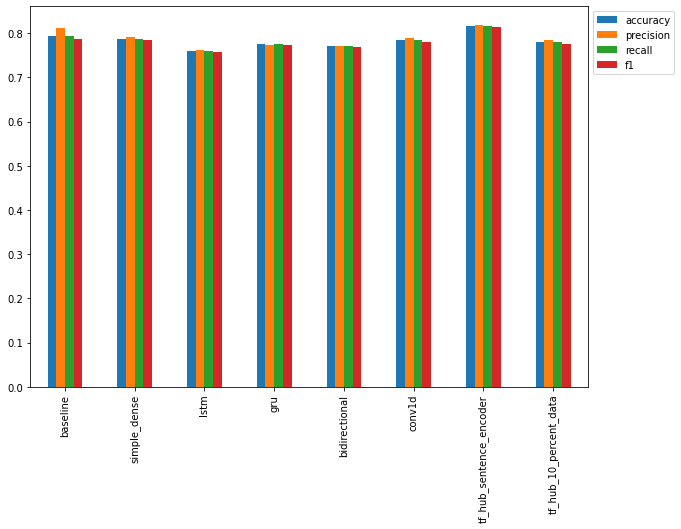

In [ ]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

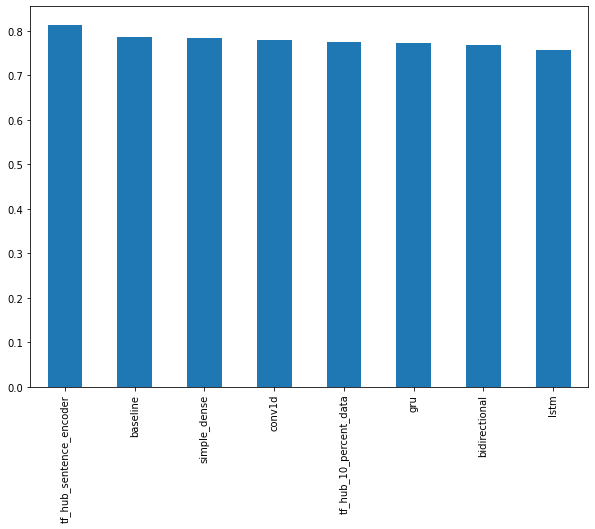

In [ ]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

### Combining Models

In [ ]:
# Get mean pred probs for 3 models
baseline_pred_probs = np.max(model_0.predict_proba(val_sentences), axis=1) # get the prediction probabilities from baseline model
combined_pred_probs = baseline_pred_probs + tf.squeeze(model_2_pred_probs, axis=1) + tf.squeeze(model_6_pred_probs)
combined_preds = tf.round(combined_pred_probs/3) # average and round the prediction probabilities to get prediction classes
combined_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

In [ ]:
# Calculate results from averaging the prediction probabilities
ensemble_results = calculate_results(val_labels, combined_preds)
ensemble_results

{'accuracy': 78.60892388451444,
 'precision': 0.7859340502399238,
 'recall': 0.7860892388451444,
 'f1': 0.7854072775649804}

In [ ]:
# Add our combined model's results to the results DataFrame
all_model_results.loc["ensemble_results"] = ensemble_results

In [ ]:
# Convert the accuracy to the same scale as the rest of the results
all_model_results.loc["ensemble_results"]["accuracy"] = all_model_results.loc["ensemble_results"]["accuracy"]/100

In [ ]:
all_model_results

,accuracy,precision,recall,f1
baseline,0.792651,0.811139,0.792651,0.786219
simple_dense,0.787402,0.791492,0.787402,0.784697
lstm,0.759843,0.761544,0.759843,0.757458
gru,0.774278,0.774059,0.774278,0.773515
bidirectional,0.770341,0.771589,0.770341,0.768449
conv1d,0.783465,0.788004,0.783465,0.780493
tf_hub_sentence_encoder,0.816273,0.819431,0.816273,0.814502
tf_hub_10_percent_data,0.779528,0.784532,0.779528,0.776274
ensemble_results,0.786089,0.785934,0.786089,0.785407


### Saving and loading trained model

In [ ]:
# Save TF Hub Sentence Encoder model to HDF5 format
model_6.save("model_6.h5")

In [ ]:
# Load model with custom Hub Layer (required with HDF5 format)
loaded_model_6 = tf.keras.models.load_model("model_6.h5", 
                                            custom_objects={"KerasLayer": hub.KerasLayer})

In [ ]:
# How does our loaded model perform?
loaded_model_6.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 8ms/step - loss: 0.4266 - accuracy: 0.8163


[0.42661479115486145, 0.8162729740142822]

In [ ]:
# Save TF Hub Sentence Encoder model to SavedModel format (default)
model_6.save("model_6_SavedModel_format")

In [ ]:
# Load TF Hub Sentence Encoder SavedModel
loaded_model_6_SavedModel = tf.keras.models.load_model("model_6_SavedModel_format")

In [ ]:
# Evaluate loaded SavedModel format
loaded_model_6_SavedModel.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 8ms/step - loss: 0.4266 - accuracy: 0.8163


[0.42661479115486145, 0.8162729740142822]

### Finding the most wrong examples

In [ ]:
# Create dataframe with validation sentences and best performing model predictions
val_df = pd.DataFrame({"text": val_sentences,
                       "target": val_labels,
                       "pred": model_6_preds,
                       "pred_prob": tf.squeeze(model_6_pred_probs)})
val_df.head()

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.161132
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.746384
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.991099
3,@camilacabello97 Internally and externally scr...,1,0.0,0.226102
4,Radiation emergency #preparedness starts with ...,1,1.0,0.724357


In [ ]:
# Find the wrong predictions and sort by prediction probabilities
most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("pred_prob", ascending=False)
most_wrong[:10]

,text,target,pred,pred_prob
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.914629
628,@noah_anyname That's where the concentration c...,0,1.0,0.876637
759,FedEx will no longer transport bioterror patho...,0,1.0,0.870962
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.834699
49,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.832704
109,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1.0,0.803515
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.803091
698,åÈMGN-AFRICAå¨ pin:263789F4 åÈ Correction: Ten...,0,1.0,0.780678
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.776062
144,The Sound of Arson,0,1.0,0.773365


In [ ]:
# Check the false positives (model predicted 1 when should've been 0)
for row in most_wrong[:10].itertuples(): # loop through the top 10 rows (change the index to view different rows)
  _, text, target, pred, prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 0, Pred: 1, Prob: 0.9146288633346558
Text:
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

----

Target: 0, Pred: 1, Prob: 0.8766369223594666
Text:
@noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.

----

Target: 0, Pred: 1, Prob: 0.8709622025489807
Text:
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

----

Target: 0, Pred: 1, Prob: 0.8346992135047913
Text:
@SonofLiberty357 all illuminated by the brightly burning buildings all around the town!

----

Target: 0, Pred: 1, Prob: 0.8327041864395142
Text:
@madonnamking RSPCA site multiple 7 story high rise buildings next to low density character residential in an area that floods

----

Target: 0, Pred: 1, Prob: 0.8035145401954651
Text:
[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES WITH MAGNE-TRACTION INSTRUCTIONS http://t.co/xEZBs3sq0y http://t.co/C2x0QoKGlY

----

Target: 0, Pred: 1, Prob: 0.803090512

In [ ]:
# Check the most wrong false negatives (model predicted 0 when should've predict 1)
for row in most_wrong[-10:].itertuples():
  _, text, target, pred, prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 1, Pred: 0, Prob: 0.06589475274085999
Text:
@DavidVonderhaar At least you were sincere ??

----

Target: 1, Pred: 0, Prob: 0.06305903941392899
Text:
'The way you move is like a full on rainstorm and I'm a house of cards'

----

Target: 1, Pred: 0, Prob: 0.06131316348910332
Text:
You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.

----

Target: 1, Pred: 0, Prob: 0.058816876262426376
Text:
@willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu

----

Target: 1, Pred: 0, Prob: 0.05853809788823128
Text:
Lucas Duda is Ghost Rider. Not the Nic Cage version but an actual 'engulfed in flames' badass. #Mets

----

Target: 1, Pred: 0, Prob: 0.04672270640730858
Text:
I get to smoke my shit in peace

----

Target: 1, Pred: 0, Prob: 0.043316882103681564
Text:
Why are you deluged with low self-image? Take the q

### Making predictions on test

In [ ]:
# Making predictions on the test dataset
test_sentences = test_df["text"].to_list()
test_samples = random.sample(test_sentences, 10)
for test_sample in test_samples:
  pred_prob = tf.squeeze(model_6.predict([test_sample])) # has to be list
  pred = tf.round(pred_prob)
  print(f"Pred: {int(pred)}, Prob: {pred_prob}")
  print(f"Text:\n{test_sample}\n")
  print("----\n")

1/1 [==============================] - 0s 42ms/step
Pred: 0, Prob: 0.04262906685471535
Text:
Throw me in the deep end watch me drown

----

1/1 [==============================] - 0s 40ms/step
Pred: 1, Prob: 0.9074686765670776
Text:
Watch This Airport Get Swallowed Up By A Sandstorm In Under A Minute http://t.co/Tr8YcHEFGQ

----

1/1 [==============================] - 0s 37ms/step
Pred: 1, Prob: 0.8339584469795227
Text:
NetNewsLedger Wild Fire Update ÛÒ August 4 2015: THUNDER BAY ÛÒ WEATHER ÛÒ ThereåÊwere no new fires confirmed by t... http://t.co/JflxgEmBdA

----

1/1 [==============================] - 0s 38ms/step
Pred: 1, Prob: 0.9680820107460022
Text:
Calgary takes another beating from summer storms; City activates emergency plan http://t.co/4oi9hMo7om

----

1/1 [==============================] - 0s 36ms/step
Pred: 1, Prob: 0.8983758687973022
Text:
Cop pulls drunk driver to safety SECONDS before his car is hit by train. http://t.co/cTL5xzIHxAåÊ http://t.co/1kDOZTD9mv via @ViralS

### Predicting on Tweets (from the wild)

In [ ]:
# Turn Tweet into string
daniels_tweet = "Life like an ensemble: take the best choices from others and make your own"

In [ ]:
def predict_on_sentence(model, sentence):
  """
  Uses model to make a prediction on sentence.

  Returns the sentence, the predicted label and the prediction probability.
  """
  pred_prob = model.predict([sentence])
  pred_label = tf.squeeze(tf.round(pred_prob)).numpy()
  print(f"Pred: {pred_label}", "(real disaster)" if pred_label > 0 else "(not real disaster)", f"Prob: {pred_prob[0][0]}")
  print(f"Text:\n{sentence}")

In [ ]:
# Make a prediction on Tweet from the wild
predict_on_sentence(model=model_6, # use the USE model
                    sentence=daniels_tweet)

1/1 [==============================] - 0s 37ms/step
Pred: 0.0 (not real disaster) Prob: 0.05480846390128136
Text:
Life like an ensemble: take the best choices from others and make your own


In [ ]:
# Source - https://twitter.com/BeirutCityGuide/status/1290696551376007168
beirut_tweet_1 = "Reports that the smoke in Beirut sky contains nitric acid, which is toxic. Please share and refrain from stepping outside unless urgent. #Lebanon"

# Source - https://twitter.com/BeirutCityGuide/status/1290773498743476224
beirut_tweet_2 = "#Beirut declared a “devastated city”, two-week state of emergency officially declared. #Lebanon"

In [ ]:
# Predict on diaster Tweet 1
predict_on_sentence(model=model_6, 
                    sentence=beirut_tweet_1)

1/1 [==============================] - 0s 37ms/step
Pred: 1.0 (real disaster) Prob: 0.9692153334617615
Text:
Reports that the smoke in Beirut sky contains nitric acid, which is toxic. Please share and refrain from stepping outside unless urgent. #Lebanon


In [ ]:
# Predict on diaster Tweet 2
predict_on_sentence(model=model_6, 
                    sentence=beirut_tweet_2)

1/1 [==============================] - 0s 36ms/step
Pred: 1.0 (real disaster) Prob: 0.9753061532974243
Text:
#Beirut declared a “devastated city”, two-week state of emergency officially declared. #Lebanon


### Speed/score tradeoff

In [ ]:
# Calculate the time of predictions
import time
def pred_timer(model, samples):
  """
  Times how long a model takes to make predictions on samples.
  
  Args:
  ----
  model = a trained model
  sample = a list of samples

  Returns:
  ----
  total_time = total elapsed time for model to make predictions on samples
  time_per_pred = time in seconds per single sample
  """
  start_time = time.perf_counter() # get start time
  model.predict(samples) # make predictions
  end_time = time.perf_counter() # get finish time
  total_time = end_time-start_time # calculate how long predictions took to make
  time_per_pred = total_time/len(val_sentences) # find prediction time per sample
  return total_time, time_per_pred

In [ ]:
# Calculate TF Hub Sentence Encoder prediction times
model_6_total_pred_time, model_6_time_per_pred = pred_timer(model_6, val_sentences)
model_6_total_pred_time, model_6_time_per_pred

24/24 [==============================] - 0s 7ms/step


(0.22774033300004248, 0.00029887182808404527)

In [ ]:
# Calculate Naive Bayes prediction times
baseline_total_pred_time, baseline_time_per_pred = pred_timer(model_0, val_sentences)
baseline_total_pred_time, baseline_time_per_pred

(0.015001981999944292, 1.96876404198744e-05)

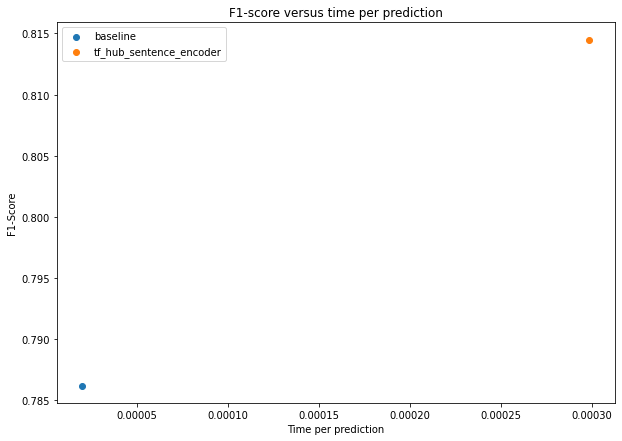

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(baseline_time_per_pred, baseline_results["f1"], label="baseline")
plt.scatter(model_6_time_per_pred, model_6_results["f1"], label="tf_hub_sentence_encoder")
plt.legend()
plt.title("F1-score versus time per prediction")
plt.xlabel("Time per prediction")
plt.ylabel("F1-Score");

## 1. Rebuild, compile and train model_1, model_2 and model_5 using the Keras Sequential API instead of the Functional API.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential


embedding_q1_m1 = layers.Embedding(input_dim=max_vocab_length, # set input shape
                             output_dim=128, # set size of embedding vector
                             embeddings_initializer="uniform", # default, intialize randomly
                             input_length=max_length, # how long is each input
                             name="embedding_q1_m1") 

model_q1_m1 = Sequential([
  layers.Input(shape=(1,), dtype="string"),
  text_vectorizer,
  embedding_q1_m1,
  layers.GlobalAveragePooling1D(),
  layers.Dense(1, activation="sigmoid")
])

# Compile model
model_q1_m1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
model_q1_m1_history = model_q1_m1.fit(train_sentences, # input sentences can be a list of strings due to text preprocessing layer built-in model
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR, 
                                                                     experiment_name="simple_dense_model_q1_m1")])


Saving TensorBoard log files to: model_logs/simple_dense_model_q1_m1/20230309-104932
Epoch 1/5
215/215 [==============================] - 7s 31ms/step - loss: 0.6111 - accuracy: 0.6903 - val_loss: 0.5369 - val_accuracy: 0.7493
Epoch 2/5
215/215 [==============================] - 2s 7ms/step - loss: 0.4411 - accuracy: 0.8192 - val_loss: 0.4696 - val_accuracy: 0.7848
Epoch 3/5
215/215 [==============================] - 1s 7ms/step - loss: 0.3461 - accuracy: 0.8615 - val_loss: 0.4594 - val_accuracy: 0.7927
Epoch 4/5
215/215 [==============================] - 1s 6ms/step - loss: 0.2847 - accuracy: 0.8926 - val_loss: 0.4646 - val_accuracy: 0.7900
Epoch 5/5
215/215 [==============================] - 1s 6ms/step - loss: 0.2379 - accuracy: 0.9120 - val_loss: 0.4771 - val_accuracy: 0.7887


In [ ]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers

embedding_q1_m2 = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_q1_m2")



model_q1_m2 = Sequential([
  layers.Input(shape=(1,), dtype="string"),
  text_vectorizer,
  embedding_q1_m2,
  layers.LSTM(64),
  layers.Dense(1, activation="sigmoid")
])

# Compile model
model_q1_m2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
model_q1_m2_history = model_q1_m2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 
                                                                     "LSTM_q1_m2")])

Saving TensorBoard log files to: model_logs/LSTM_q1_m2/20230309-104953
Epoch 1/5
215/215 [==============================] - 9s 33ms/step - loss: 0.5121 - accuracy: 0.7427 - val_loss: 0.4534 - val_accuracy: 0.7861
Epoch 2/5
215/215 [==============================] - 2s 9ms/step - loss: 0.3188 - accuracy: 0.8691 - val_loss: 0.5002 - val_accuracy: 0.7848
Epoch 3/5
215/215 [==============================] - 2s 8ms/step - loss: 0.2190 - accuracy: 0.9171 - val_loss: 0.5898 - val_accuracy: 0.7690
Epoch 4/5
215/215 [==============================] - 2s 8ms/step - loss: 0.1528 - accuracy: 0.9451 - val_loss: 0.6549 - val_accuracy: 0.7782
Epoch 5/5
215/215 [==============================] - 2s 8ms/step - loss: 0.1092 - accuracy: 0.9578 - val_loss: 0.8700 - val_accuracy: 0.7546


In [ ]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers

embedding_q1_m3 = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_q1_m3")



model_q1_m3 = Sequential([
  layers.Input(shape=(1,), dtype="string"),
  text_vectorizer,
  embedding_q1_m3,
  layers.GRU(64),
  layers.Dense(1, activation="sigmoid")
])

# Compile model
model_q1_m3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


# Fit model
model_q1_m3_history = model_q1_m3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "GRU_q1_m3")])

Saving TensorBoard log files to: model_logs/GRU_q1_m3/20230309-105010
Epoch 1/5
215/215 [==============================] - 9s 32ms/step - loss: 0.5309 - accuracy: 0.7237 - val_loss: 0.4558 - val_accuracy: 0.7743
Epoch 2/5
215/215 [==============================] - 2s 9ms/step - loss: 0.3184 - accuracy: 0.8702 - val_loss: 0.4887 - val_accuracy: 0.7782
Epoch 3/5
215/215 [==============================] - 2s 9ms/step - loss: 0.2142 - accuracy: 0.9204 - val_loss: 0.5578 - val_accuracy: 0.7717
Epoch 4/5
215/215 [==============================] - 2s 7ms/step - loss: 0.1495 - accuracy: 0.9482 - val_loss: 0.6248 - val_accuracy: 0.7782
Epoch 5/5
215/215 [==============================] - 2s 7ms/step - loss: 0.1127 - accuracy: 0.9619 - val_loss: 0.6079 - val_accuracy: 0.7690


In [ ]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers


embedding_q1_m5 = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_q1_m5")

model_q1_m5 = Sequential([
  layers.Input(shape=(1,), dtype="string"),
  text_vectorizer,
  embedding_q1_m5,
  layers.Conv1D(filters=32, kernel_size=5, activation="relu"),
  layers.GlobalMaxPool1D(),
  layers.Dense(1, activation="sigmoid")
])

# Compile model
model_q1_m5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


# Fit the model
model_q1_m5_history = model_q1_m5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 
                                                                     "Conv1D_q1_m5")])


Saving TensorBoard log files to: model_logs/Conv1D_q1_m5/20230309-105026
Epoch 1/5
215/215 [==============================] - 8s 31ms/step - loss: 0.5653 - accuracy: 0.7155 - val_loss: 0.4713 - val_accuracy: 0.7756
Epoch 2/5
215/215 [==============================] - 2s 8ms/step - loss: 0.3425 - accuracy: 0.8603 - val_loss: 0.4744 - val_accuracy: 0.7861
Epoch 3/5
215/215 [==============================] - 2s 8ms/step - loss: 0.2177 - accuracy: 0.9203 - val_loss: 0.5333 - val_accuracy: 0.7703
Epoch 4/5
215/215 [==============================] - 1s 6ms/step - loss: 0.1419 - accuracy: 0.9520 - val_loss: 0.6015 - val_accuracy: 0.7743
Epoch 5/5
215/215 [==============================] - 1s 7ms/step - loss: 0.0993 - accuracy: 0.9669 - val_loss: 0.6566 - val_accuracy: 0.7874


### Calculate Results

In [ ]:
test_sentences = test_df["text"].to_numpy()

In [ ]:
model_q1_m1_pred_probs = model_q1_m1.predict(val_sentences)
model_q1_m2_pred_probs = model_q1_m2.predict(val_sentences)
model_q1_m3_pred_probs = model_q1_m3.predict(val_sentences)
model_q1_m5_pred_probs = model_q1_m5.predict(val_sentences)

24/24 [==============================] - 0s 2ms/step


In [ ]:
model_q1_m1_preds = tf.squeeze(tf.round(model_q1_m1_pred_probs)) 
model_q1_m2_preds = tf.squeeze(tf.round(model_q1_m2_pred_probs)) 
model_q1_m3_preds = tf.squeeze(tf.round(model_q1_m3_pred_probs)) 
model_q1_m5_preds = tf.squeeze(tf.round(model_q1_m5_pred_probs)) 

### Compared with Originals

In [ ]:
model_1.summary(), model_q1_m1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

(None, None)

In [ ]:
model_2.summary(), model_q1_m2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_2 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
____________________________________________

(None, None)

In [ ]:
model_3.summary(), model_q1_m3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_3 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_____________________________________________

(None, None)

In [ ]:
model_5.summary(), model_q1_m5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_5 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 32)            20512     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 1)              

(None, None)

In [ ]:
calculate_results(val_labels, model_1_preds), calculate_results(val_labels, model_q1_m1_preds)

({'accuracy': 78.74015748031496,
  'precision': 0.7914920592553047,
  'recall': 0.7874015748031497,
  'f1': 0.7846966492209201},
 {'accuracy': 78.87139107611549,
  'precision': 0.7930566476728028,
  'recall': 0.7887139107611548,
  'f1': 0.7859560656123432})

In [ ]:
calculate_results(val_labels, model_2_preds), calculate_results(val_labels, model_q1_m2_preds)

({'accuracy': 75.98425196850394,
  'precision': 0.7615439957650938,
  'recall': 0.7598425196850394,
  'f1': 0.7574575318690253},
 {'accuracy': 75.45931758530183,
  'precision': 0.7549417854127627,
  'recall': 0.7545931758530183,
  'f1': 0.7529524951810874})

In [ ]:
calculate_results(val_labels, model_3_preds), calculate_results(val_labels, model_q1_m3_preds)

({'accuracy': 77.42782152230971,
  'precision': 0.7740592463511713,
  'recall': 0.7742782152230971,
  'f1': 0.7735154339779791},
 {'accuracy': 76.9028871391076,
  'precision': 0.7691242349168363,
  'recall': 0.7690288713910761,
  'f1': 0.7678647757387915})

In [ ]:
calculate_results(val_labels, model_5_preds), calculate_results(val_labels, model_q1_m5_preds)

({'accuracy': 78.34645669291339,
  'precision': 0.7880043492637875,
  'recall': 0.7834645669291339,
  'f1': 0.7804929895574078},
 {'accuracy': 78.74015748031496,
  'precision': 0.7897494631352898,
  'recall': 0.7874015748031497,
  'f1': 0.7853521734440729})

## 2. Retrain the baseline model with 10% of the training data. How does perform compared to the Universal Sentence Encoder model with 10% of the training data?

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_q2 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                    ("clf", MultinomialNB()) # model the text
])


In [ ]:
model_q2.fit(train_sentences_90_percent, train_labels_90_percent)


Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
baseline_preds_10_percent = model_q2.predict(train_sentences_10_percent)

In [ ]:
# Get baseline results
baseline_results_10_percent = calculate_results(
    y_true=train_labels_10_percent,
    y_pred=baseline_preds_10_percent
)

In [ ]:
compare_baseline_to_new_results(baseline_results_10_percent, model_7_results)

Baseline accuracy: 83.38, New accuracy: 77.95, Difference: -5.43
Baseline precision: 0.84, New precision: 0.78, Difference: -0.05
Baseline recall: 0.83, New recall: 0.78, Difference: -0.05
Baseline f1: 0.83, New f1: 0.78, Difference: -0.05


## 3. Try fine-tuning the TF Hub Universal Sentence Encoder model by setting training=True when instantiating it as a Keras layer.

```
We can use this encoding layer in place of our text_vectorizer and embedding layer

sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=True) # turn training on to fine-tune the TensorFlow Hub model
```

1. Retrain the best model you've got so far on the whole training set (no validation split). Then use this trained model to make predictions on the test dataset and format the predictions into the same format as the sample_submission.csv file from Kaggle (see the Files tab in Colab for what the sample_submission.csv file looks like). Once you've done this, make a submission to the Kaggle competition, how did your model perform?
2. Combine the ensemble predictions using the majority vote (mode), how does this perform compare to averaging the prediction probabilities of each model?
3. Make a confusion matrix with the best performing model's predictions on the validation set and the validation ground truth labels.